   # **SMS SPAM TESPİTİ**

Metin verisi işleme, makine öğrenmesi modeli oluşturma ve değerlendirme için kapsamlı bir kütüphane seti içe aktarılmıştır. pandas veri yönetimi için, re ve string metin temizliği ve düzenlemesi için kullanılır. Veri setini eğitim ve test olarak bölmek için train_test_split, metinleri sayısal vektörlere dönüştürmek için TfidfVectorizer tercih edilmiştir. Model oluşturma ve optimizasyon aşamalarında Naive Bayes, Lojistik Regresyon, Random Forest, SVM gibi çeşitli sınıflandırıcılar ile birlikte GridSearchCV ve StratifiedKFold gibi çapraz doğrulama ve hiperparametre ayarlama araçları kullanılmıştır. Pipeline yapısı, veri dönüşümü ve model aşamalarını entegre ederek iş akışını kolaylaştırır. Performans ölçümleri için doğruluk, sınıflandırma raporu, karışıklık matrisi ve görselleştirme araçları (matplotlib, seaborn) yer almakta, ayrıca nltk ve collections.Counter metin analizlerinde destek sağlar. Bu hazırlık, kapsamlı ve esnek bir metin sınıflandırma projesi için gerekli tüm araçları içermektedir.

In [1]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random, numpy as np, os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
from collections import Counter
from sklearn.preprocessing import LabelEncoder



Bu komutlar, Python ortamına trnlp ve nltk kütüphanelerini yüklemek için kullanılır. trnlp, özellikle Türkçe doğal dil işleme görevlerinde yardımcı olan bir kütüphane iken, nltk (Natural Language Toolkit) doğal dil işleme alanında geniş kapsamlı araçlar ve veri setleri sunar. Bu kütüphaneler, metinlerin analiz edilmesi, ön işlenmesi ve doğal dil işleme uygulamalarının geliştirilmesi için temel altyapıyı sağlar.

In [2]:
!pip install trnlp
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for trnlp: filename=trnlp-0.2.3a0-py3-none-any.whl size=10168260 sha256=1c030e8e6706df45f706d25a23bb0d77298593c7b19408e4776d41bed8586935
  Stored in directory: /root/.cache/pip/wheels/f5/75/d1/fb5c7ad584aafd96ae8d425dcdb7e64296f729fcb2eeccf26b
Successfully built trnlp


Bu kod satırında, pandas kütüphanesi kullanılarak belirtilen Excel dosyasından bir veri seti (karistirilmis_sms_dataset.xlsx) yüklenmektedir. df değişkeni, veri setini bir DataFrame olarak saklar ve df.head() fonksiyonu veri setinin ilk 5 satırını görüntüleyerek veri yapısının genel yapısını ve içeriğini hızlıca incelemeyi sağlar. df.info() ifadesi, Pandas DataFrame'in yapısı hakkında özet bilgi verir.Bu adım, veri analizine başlamadan önce veri setinin temel özelliklerini anlamak için standart bir uygulamadır.

In [3]:
df = pd.read_excel("/kaggle/input/sonveriseti/guncellenmis_sms_dataset.xlsx")  # örnek
df.head()


,label,message
0,spam,KAYIT VE INDIRME LINKLERI AKTIF!Turkiyenin rek...
1,ham,Hattiniz kapaliyken sizi arayan +905300515079 ...
2,ham,kütüphanedeyim
3,spam,Ramazana Özel Yeni Kayıtlara 12.500 EM + 5000 ...
4,ham,Starbucks Turkiye hesabinizin parolasini yenil...


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    2060 non-null   object
 1   message  2060 non-null   object
dtypes: object(2)
memory usage: 32.3+ KB


Veri setindeki sınıf dağılımını iki farklı görselle birlikte sunar. İlk olarak, seaborn kütüphanesi ile çubuk grafik (countplot) çizilerek her sınıfa ait örnek sayısı gösterilir. Yanında ise matplotlib kullanılarak pasta grafiği çizilir ve sınıfların toplam veri içerisindeki yüzdesel oranları görsel olarak ifade edilir. Bu çift grafik, hem sınıf adetlerini hem de oranlarını aynı anda inceleyerek veri dengesizliği ve dağılımı hakkında daha kapsamlı bilgi edinmeyi sağlar.

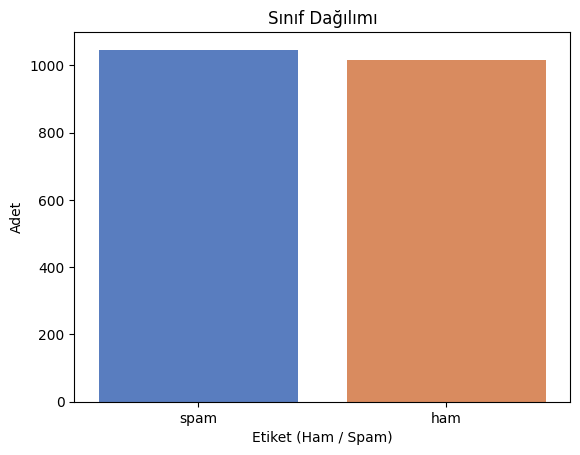

In [5]:
sns.countplot(data=df, x='label', palette='muted')
plt.title("Sınıf Dağılımı")
plt.xlabel("Etiket (Ham / Spam)")
plt.ylabel("Adet")
plt.show()


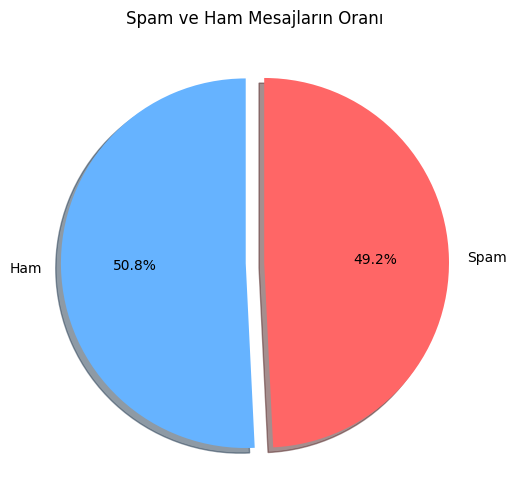

In [6]:

# Sınıf dağılımını say
counts = df['label'].value_counts()
labels = ['Ham', 'Spam']

# Pasta grafiği çiz
plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], startangle=90, explode=(0.05, 0.05), shadow=True)
plt.title('Spam ve Ham Mesajların Oranı')
plt.show()


Bu kod satırında, veri setindeki label sütunundaki kategorik metin değerleri sayısal değerlere dönüştürülmektedir. 'ham' etiketi 0, 'spam' etiketi ise 1 olarak eşlenerek, sınıflar ikili (binary) formata getirilir. Bu dönüşüm, makine öğrenmesi modellerinin çalışabilmesi için gereklidir çünkü çoğu algoritma sayısal veri ile işlem yapar.

In [7]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df

,label,message
0,1,KAYIT VE INDIRME LINKLERI AKTIF!Turkiyenin rek...
1,0,Hattiniz kapaliyken sizi arayan +905300515079 ...
2,0,kütüphanedeyim
3,1,Ramazana Özel Yeni Kayıtlara 12.500 EM + 5000 ...
4,0,Starbucks Turkiye hesabinizin parolasini yenil...
...,...,...
2055,1,ŞOK Market: 500₺ alışveriş çeki kazandınız. Ku...
2056,1,Microsoft: Hesabınıza şüpheli bir yazılım bula...
2057,1,Kargo Takip: Yurt dışı paketiniz gümrükte bekl...
2058,1,ÖSYM: Sınav başvurunuz geçersiz sayılmıştır. T...


# **VERİ ÖN İŞLEME**

Bu kod bloğu, Türkçe metinleri temizlemek ve ön işleme tabi tutmak için kapsamlı bir fonksiyon tanımlar. Öncelikle, bir JSON dosyasından Türkçe stop-word (önemsiz kelimeler) listesi yüklenir ve arama hızını artırmak için set veri yapısına dönüştürülür. temizle_stopwords fonksiyonu, verilen metni önce küçük harfe çevirir, URL adreslerini ve “b123” gibi operatör etiketlerini düzenli ifadelerle kaldırır, sayıları ve noktalama işaretlerini temizler. Ayrıca, metindeki fazla boşlukları tek boşluğa indirger. Son olarak, metni kelimelere ayırır ve stop-word listesinde bulunan ya da tek harfli kelimeleri çıkararak temizlenmiş ve gereksiz kelimelerden arındırılmış bir metin döner. Bu ön işleme, doğal dil işleme modellerinin doğruluğunu artırmak için önemli bir adımdır.

In [8]:
import unicodedata

with open('/kaggle/input/turkce-stopwords/turkce_stopwords1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    turkce_stopwords = set(data['stopwords'])  # Set olarak almak arama hızını artırır

def temizle_stopwords(text):
    # 2. Küçük harfe çevir
    text = text.lower()

    # 4. Telefon numarası gibi uzun rakam dizilerini maskele
    text = re.sub(r'\b\d{7,}\b', ' NUMARA ', text)

    # 7. Tek karakterli kelimeleri ve boşlukları sadeleştir
    text = re.sub(r'\b\w\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Kelimeleri parçala ve stopword’leri çıkar
    kelimeler = text.split()
    kelimeler = [k for k in kelimeler if k not in turkce_stopwords and len(k) > 1]

    return ' '.join(kelimeler)


In [9]:
def orta_duzey_on_isleme(text):
    temiz = temizle_stopwords(text)
    return temiz


In [10]:
df['message_cleaned'] = df['message'].apply(orta_duzey_on_isleme)


In [11]:
print(df[['message', 'message_cleaned']].sample(5))


                                                message  \
1030  Bugün dışarı çıkacaksan şemsiye al, yağmur bas...   
193   Size özel bir video mesajı var! İzlemek için t...   
1921  Bankanız: XXXX nolu kartınızla yapılan 150.75 ...   
1165  Banka kartınız basılmıştır. 3 iş günü içinde a...   
456   Evren2'de Kayıtlar ve İndirmeler Açıldı, Ön Ka...   

                                        message_cleaned  
1030  bugün dışarı çıkacaksan şemsiye al, yağmur bas...  
193   size özel video mesajı var! ̇zlemek tıklayın: ...  
1921  bankanız: xxxx nolu kartınızla 150.75 tl tutar...  
1165  banka kartınız basılmıştır. günü içinde adresi...  
456   evren2'de kayıtlar ̇ndirmeler açıldı, ön kayıt...  


Metin verisi üzerinde temel istatistiksel özellikler çıkararak veri analizi için önemli öznitelikler (feature’lar) oluşturur.

**No_of_Characters:** Her bir temizlenmiş mesajdaki toplam karakter sayısını hesaplar.

**No_of_Words:** nltk kütüphanesinin word_tokenize fonksiyonu kullanılarak her mesajdaki kelime sayısını belirler.

**No_of_Sentences:** nltk'nin sent_tokenize fonksiyonu ile her mesajdaki cümle sayısı hesaplanır.

Son olarak, groupby('label') ile mesajlar "ham" veya "spam" olarak sınıflandırılır ve bu sınıflara göre karakter, kelime ve cümle sayılarının temel istatistikleri (ortalama, standart sapma vb.) özetlenir. Bu tür öznitelikler, mesajların yapısal farklılıklarını analiz ederek model performansını artırmaya yardımcı olabilir.

In [12]:
#nltk.download('punkt')  # Eğer nltk tokenizasyon paketleri indirilmediyse

# Karakter sayısı
df['No_of_Characters'] = df['message_cleaned'].apply(len)

# Kelime sayısı
df['No_of_Words'] = df['message_cleaned'].apply(lambda x: len(nltk.word_tokenize(x)))

# Cümle sayısı
df['No_of_Sentences'] = df['message_cleaned'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Sonuçların özetine bakalım
df.groupby('label')[['No_of_Characters', 'No_of_Words', 'No_of_Sentences']].describe().T


label                             0            1
No_of_Characters count  1014.000000  1046.000000
                 mean    130.462525   136.994264
                 std     114.977967    41.474036
                 min       0.000000    49.000000
                 25%      49.000000   129.000000
                 50%      81.000000   137.000000
                 75%     177.750000   144.000000
                 max     810.000000   432.000000
No_of_Words      count  1014.000000  1046.000000
                 mean     18.519724    20.979924
                 std      14.912946     7.410879
                 min       0.000000     7.000000
                 25%       8.000000    18.000000
                 50%      12.000000    21.000000
                 75%      25.000000    23.000000
                 max     116.000000    66.000000
No_of_Sentences  count  1014.000000  1046.000000
                 mean      2.001972     2.153920
                 std       1.215236     1.171520
                 min       0.000000     1.000000
                 25%       1.000000     1.000000
                 50%       2.000000     2.000000
                 75%       3.000000     3.000000
                 max       8.000000     7.000000

Veri setindeki mesajların yapısal özelliklerini farklı grafiklerle analiz etmeye yöneliktir.

**Boxplot**:
No_of_Characters değişkeninin sınıflara (Ham=0, Spam=1) göre dağılımını kutu grafik (boxplot) ile gösterir. Bu sayede karakter sayısındaki medyan, çeyrekler ve uç değerler spam ve ham mesajlar arasında karşılaştırılır.

**Scatterplot**:
Karakter sayısı ile kelime sayısı arasındaki ilişkiyi gösterir. Noktalar, mesajların sınıfına göre (yeşil: ham, kırmızı: spam) renklendirilmiştir. Böylece iki özellik arasındaki korelasyon görsel olarak incelenir.

**Histogram (Mesaj Uzunluğu):**
Mesaj uzunluğunun (karakter sayısı bazında) spam ve ham mesajlar için dağılımını yoğunluk eğrisi (KDE) ile birlikte sunar.

**Histogram (Kelime Sayısı):**
Kelime sayısının sınıflara göre dağılımı gösterilir; spam mesajlar kırmızı, ham mesajlar yeşil renkte gösterilmiştir.

Bu görselleştirmeler, spam ve ham mesajların yapısal özelliklerinin farklılıklarını ortaya koyar ve bu farkların makine öğrenmesi modellerinde kullanılacak özniteliklerin seçilmesinde rehberlik eder.

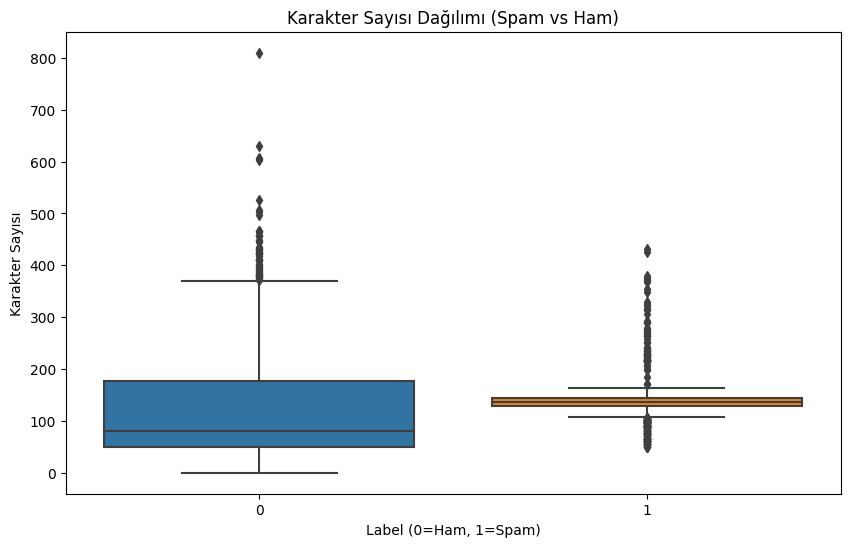

In [13]:

plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='No_of_Characters', data=df)
plt.title('Karakter Sayısı Dağılımı (Spam vs Ham)')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Karakter Sayısı')
plt.show()


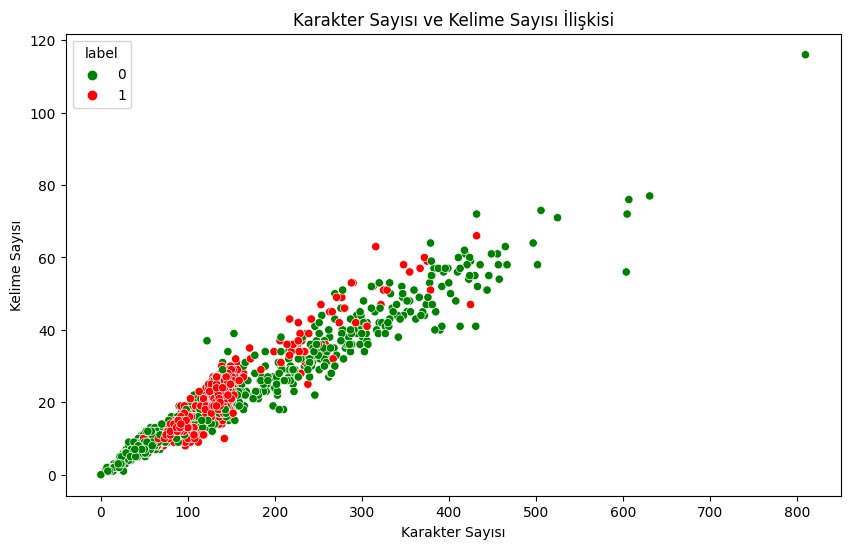

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='No_of_Characters', y='No_of_Words', hue='label', data=df, palette=['green','red'])
plt.title('Karakter Sayısı ve Kelime Sayısı İlişkisi')
plt.xlabel('Karakter Sayısı')
plt.ylabel('Kelime Sayısı')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

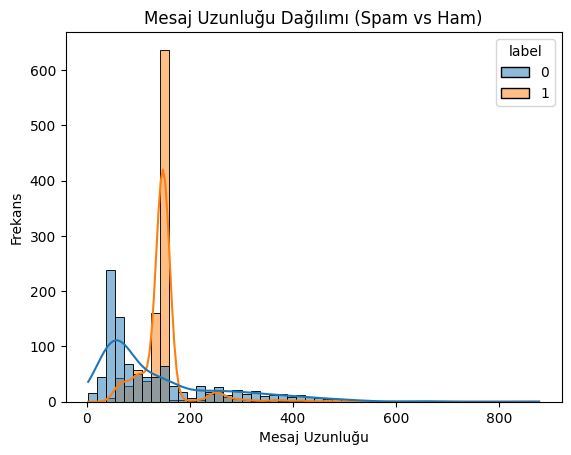

In [15]:
df['message_length'] = df['message'].apply(len)
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Mesaj Uzunluğu Dağılımı (Spam vs Ham)")
plt.xlabel("Mesaj Uzunluğu")
plt.ylabel("Frekans")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

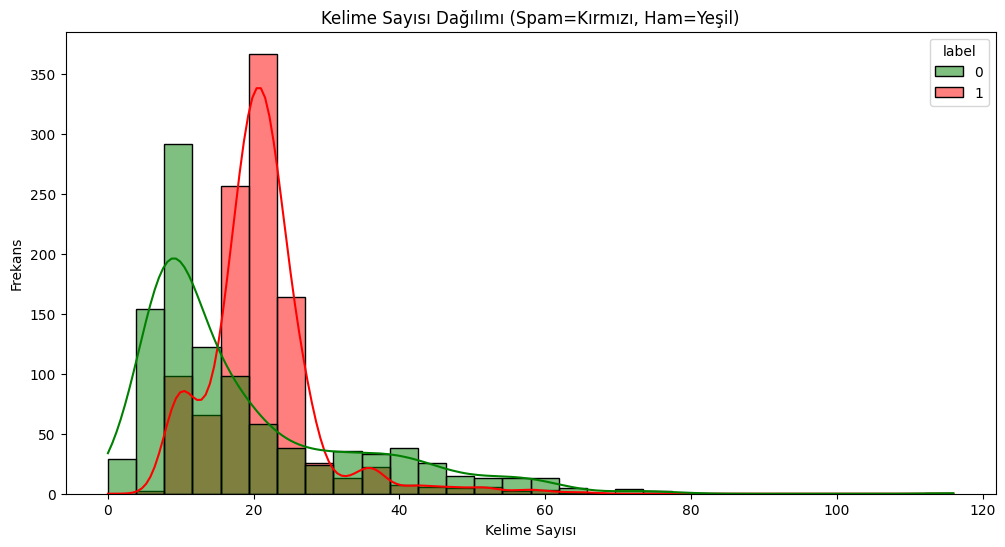

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='No_of_Words', hue='label', bins=30, kde=True, palette=['green','red'])
plt.title('Kelime Sayısı Dağılımı (Spam=Kırmızı, Ham=Yeşil)')
plt.xlabel('Kelime Sayısı')
plt.ylabel('Frekans')
plt.show()


# **MODEL OPTİMİZASYONU ve EĞİTİMİ**

Temizlenmiş metin verisi (message_cleaned) ve bunlara karşılık gelen etiketleri (label) kullanarak veri setini eğitim ve test olarak ikiye böler.

X değişkeni, makine öğrenmesi modeline girdi olarak verilecek olan önceden temizlenmiş mesajları içerir.

y değişkeni ise bu mesajların spam (1) veya ham (0) olduğunu belirten sınıf etiketlerini tutar.

train_test_split fonksiyonu, veriyi %80 eğitim ve %20 test olarak rastgele ayırır. random_state=42 parametresi, veri bölme işleminin tekrarlanabilirliğini sağlar. Böylece model eğitiminde kullanılacak veri ile doğrulama için kullanılacak test verisi ayrılmış olur.

In [17]:
# Veri ve etiketler
X = df['message_cleaned']  # Ön işlemeyi uyguladığın sütun
y = df['label']  # 0 veya 1 olarak spam etiketi

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Naive Bayes sınıflandırıcısı için bir makine öğrenmesi pipeline’ı oluşturup hiperparametre optimizasyonu yapar:

**Pipeline:**
Öncelikle TfidfVectorizer ile metin verileri 1 ve 2 gramlı kelime öbekleri bazında TF-IDF vektörlerine dönüştürülür. Vektör boyutu max_features=3000 ile sınırlandırılır. Ardından MultinomialNB sınıflandırıcısı kullanılır.

**Parametre Arama (GridSearchCV):**
TF-IDF vektörleyicide max_df ve min_df (kelime filtreleme eşikleri) ile Naive Bayes modelinin alpha (düzeltme parametresi) değerleri için çapraz doğrulama (5 katmanlı) ile en iyi kombinasyon bulunur. Model f1 skoruna göre optimize edilir.

**Model Eğitimi ve Tahmin:**
En iyi parametrelerle pipeline X_train ve y_train üzerinde eğitilir. Sonrasında test seti X_test üzerinde tahminler yapılır (y_pred_nb).

Bu süreç, Naive Bayes sınıflandırıcısının metin sınıflandırma görevindeki performansını iyileştirmek için otomatik parametre ayarı sağlar.

In [18]:
# Naive Bayes
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

param_grid_nb = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__min_df': [1, 2],
    'clf__alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, scoring='f1', n_jobs=-1)
grid_nb.fit(X_train, y_train)
best_nb = grid_nb.best_estimator_

# Tahmin yap
y_pred_nb = best_nb.predict(X_test)


Metin sınıflandırma için Lojistik Regresyon (Logistic Regression) modelinin bir pipeline ile kurulup hiperparametre optimizasyonu yapıldığı aşamaları gösterir:

**Pipeline:**
Öncelikle TfidfVectorizer kullanılarak metinler 1 ve 2 gramlık kelime öbeklerine göre TF-IDF vektörlerine dönüştürülür. Maksimum özellik sayısı 3000 olarak sınırlandırılmıştır. Daha sonra bu vektörler, LogisticRegression sınıflandırıcısına beslenir. Modelin maksimum iterasyon sayısı 1000 olarak ayarlanmıştır.

**Hiperparametre Arama (GridSearchCV):**
TF-IDF vektörleştirici için max_df ve min_df parametreleri ile Lojistik Regresyonun düzenleme gücünü kontrol eden C parametresi farklı değerler alarak 5 katlı çapraz doğrulama ile en iyi parametreler bulunur. Optimize etme ölçütü olarak f1 skoru kullanılır.

**Model Eğitimi ve Tahmin:**
Eğitim verisi üzerinde en iyi parametrelerle model eğitilir ve ardından test setindeki veriler için tahminler (y_pred_lr) yapılır.

Bu yapı, Lojistik Regresyon modelinin metin sınıflandırma görevindeki performansını artırmak için parametrelerin sistematik olarak ayarlanmasını sağlar.

In [19]:

pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__min_df': [1, 2],
    'clf__C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)


Metin sınıflandırma için Rastgele Orman (Random Forest) modelinin kurulması, hiperparametre optimizasyonu ve test verisi üzerinde tahmin yapılmasını kapsamaktadır:

**Rastgelelik Sabitleme:**
random.seed(42), np.random.seed(42) ve os.environ['PYTHONHASHSEED'] = '42' komutlarıyla tüm rastgelelik kaynakları sabitlenerek deneylerin tekrarlanabilirliği sağlanır.

**Pipeline:**
TfidfVectorizer ile metinler 1 ve 2 kelimelik n-gramlar olarak TF-IDF vektörlerine dönüştürülür. Maksimum özellik sayısı 3000 olarak sınırlandırılmıştır. Ardından bu vektörler, RandomForestClassifier modeline beslenir. Modelin random_state parametresi 42 olarak ayarlanmıştır.

**Hiperparametre Arama:**
max_df, min_df (TF-IDF vektörleştirici için), n_estimators (ağaç sayısı) ve max_depth (ağaç derinliği) parametreleri farklı değerlerle denenir. Beş katlı stratifikasyonlu çapraz doğrulama (StratifiedKFold) kullanılarak en iyi parametre kombinasyonu seçilir. Değerlendirme metriği olarak F1 skoru kullanılmıştır.

**Model Eğitimi ve Tahmin**:
En iyi parametrelerle model eğitilir ve test verisi üzerinde sınıflandırma tahminleri yapılır (y_pred_rf).

Bu yapı, Random Forest modelinin parametrelerini optimize ederek metin sınıflandırmadaki performansını artırmaya yöneliktir

In [20]:

# Sabit rastgelelik
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Model ve pipeline
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__min_df': [1, 2],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Tahmin
y_pred_rf = best_rf.predict(X_test)


Metin sınıflandırması için Destek Vektör Makineleri (SVM) modelinin oluşturulması, hiperparametre optimizasyonu ve test verisi üzerinde tahmin yapılmasını içermektedir:

**Pipeline Kurulumu:**
Metin verisi, TfidfVectorizer ile TF-IDF özelliklerine dönüştürülür. Vektörleştirici, maksimum 3000 özelliğe ve 1-2 kelimelik n-gram aralığına göre yapılandırılmıştır. Ardından, LinearSVC sınıflandırıcısı ile metinler sınıflandırılır.

**Hiperparametre Ayarı:**
GridSearchCV ile TF-IDF için max_df ve min_df parametreleri ile SVM modelinin C (düzenleme parametresi) değerleri çeşitli kombinasyonlarla denenir. 5 katlı çapraz doğrulama (cv=5) uygulanır ve modelin başarısı F1 skoru ile değerlendirilir.

**Model Eğitimi ve Tahmin:**
En iyi parametrelerle seçilen model (best_svm) eğitim verisi üzerinde eğitilir ve test seti üzerinde sınıflandırma tahminleri (y_pred_svm) gerçekleştirilir.

Bu yapı, SVM modelinin metin sınıflandırmadaki performansını artırmak için uygun parametrelerin sistematik olarak bulunmasını sağlar.

In [21]:

pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', LinearSVC())
])

param_grid_svm = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__min_df': [1, 2],
    'clf__C': [0.1, 1, 10]
}

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)


SMS mesajlarının spam olup olmadığını sınıflandırmak için dört farklı makine öğrenmesi modeli karşılaştırılmıştır: Naive Bayes, Lojistik Regresyon, Rastgele Orman (Random Forest) ve Destek Vektör Makineleri (SVM). Her model için bir pipeline tanımlanmış ve metin verisi üzerinde TF-IDF (Term Frequency-Inverse Document Frequency) dönüşümü uygulanmıştır.

Modellerin performanslarını artırmak amacıyla, her pipeline için farklı hiperparametre kombinasyonları GridSearchCV yöntemiyle çapraz doğrulama (3 katlı CV) kullanılarak optimize edilmiştir. Optimize edilen hiperparametreler arasında TF-IDF’nin max_df ve ngram_range değerleri ile model özel parametreleri (örneğin Naive Bayes için alpha, Lojistik Regresyon ve SVM için C, Random Forest için n_estimators) yer almaktadır.

Her modelin eğitim süreci sonunda, test verisi üzerinde tahminler yapılmış ve sınıflandırma performansı doğruluk (accuracy), kesinlik (precision), duyarlılık (recall) ve F1-skora göre değerlendirilmiştir. F1-skor, özellikle dengesiz sınıf dağılımı bulunan spam verilerinde hem hatalı pozitif hem de hatalı negatif sonuçları dengeleyerek model performansını özetleyen önemli bir metriktir.

In [22]:
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Modelleri ve pipeline’ları sözlük olarak tanımla
pipelines = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
        ('clf', LinearSVC())
    ])
}

# Parametre gridleri
params = {
    'Naive Bayes': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__min_df': [1, 2],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    'Logistic Regression': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__min_df': [1, 2],
        'clf__C': [0.1, 1, 10]
    },
    'Random Forest': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__min_df': [1, 2],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    },
    'SVM': {
        'tfidf__max_df': [0.5, 0.75],
        'tfidf__min_df': [1, 2],
        'clf__C': [0.1, 1, 10]
    }
}

# Sonuçları saklamak için
results = []

# Model eğitim ve değerlendirme döngüsü
for model_name, pipeline in pipelines.items():
    print(f"Model: {model_name}")
    
    if model_name == 'Random Forest':
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        cv = 5  # diğerleri için klasik 5-fold

    grid = GridSearchCV(pipeline, params[model_name], cv=cv, n_jobs=-1, scoring='f1')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'Model': model_name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
    })
    
    print(f"Best params: {grid.best_params_}")
    print(f"F1-Score: {report['1']['f1-score']:.4f}")
    print('-' * 40)

# Sonuçları tablo halinde göster
results_df = pd.DataFrame(results)
print(results_df)


Model: Naive Bayes
Best params: {'clf__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2}
F1-Score: 0.9476
----------------------------------------
Model: Logistic Regression
Best params: {'clf__C': 10, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2}
F1-Score: 0.9843
----------------------------------------
Model: Random Forest
Best params: {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1}
F1-Score: 0.9822
----------------------------------------
Model: SVM
Best params: {'clf__C': 10, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2}
F1-Score: 0.9865
----------------------------------------
                 Model                                        Best Params  \
0          Naive Bayes  {'clf__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfi...   
1  Logistic Regression  {'clf__C': 10, 'tfidf__max_df': 0.5, 'tfidf__m...   
2        Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
3                  SVM  {'clf__C': 10, 'tfidf__max_df': 0.5, 

# **MODEL GÖRSELLEŞTİRMELERİ ve GRAFİKLER**

Model karşılaştırma sonuçları bir pandas DataFrame'e dönüştürülerek, her modelin test veri setindeki doğruluk (accuracy) değerleri görselleştirilmiştir. Matplotlib ve seaborn kütüphaneleri kullanılarak oluşturulan barplot grafik, modellerin performanslarını yan yana kıyaslamayı kolaylaştırmaktadır.

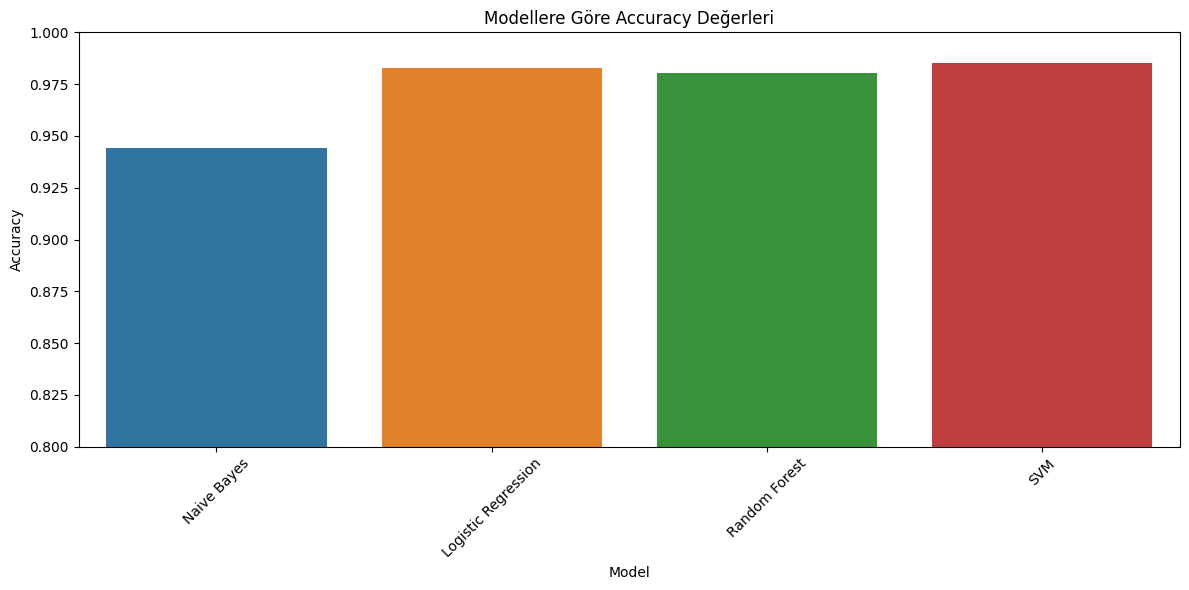

In [23]:
# Eğer hala listeyse
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title("Modellere Göre Accuracy Değerleri")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)  # Daha net görmek için
plt.tight_layout()
plt.show()


Bu grafik, farklı makine öğrenmesi modellerinin test verisi üzerindeki F1 skorlarını karşılaştırmak amacıyla oluşturulmuştur. F1 skoru, modelin doğruluk ve geri çağırma (recall) performansını dengeleyen önemli bir metriktir ve özellikle dengesiz sınıflar için tercih edilir. Grafikte, modellerin F1 skorları 0.8 ile 1.0 aralığında gösterilerek, en başarılı modellerin performans farkları net bir şekilde ortaya konmuştur.

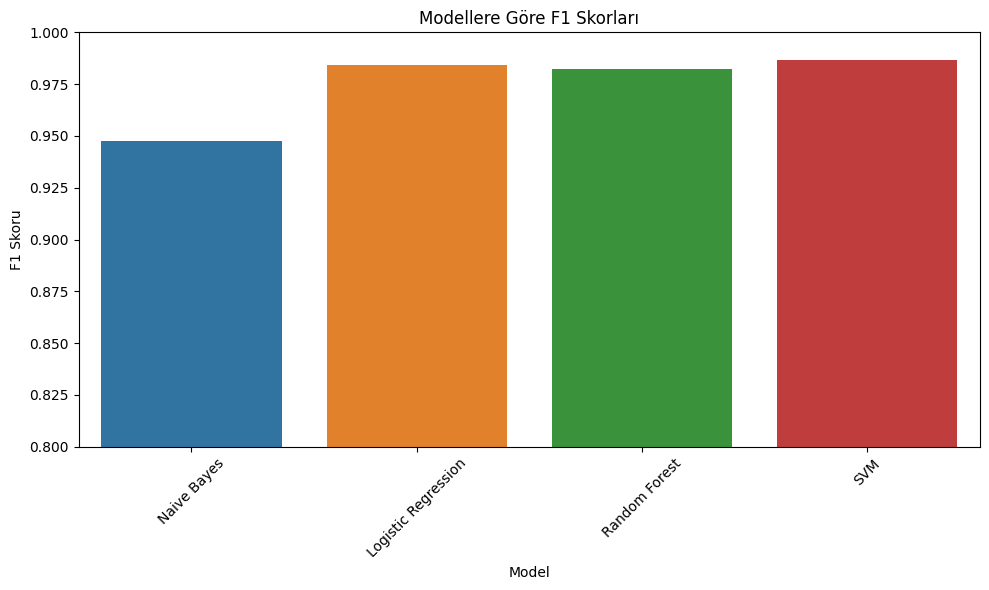

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='F1-Score')
plt.title("Modellere Göre F1 Skorları")
plt.ylabel("F1 Skoru")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)  # Daha net görmek için
plt.tight_layout()
plt.show()


Bu grafikler, farklı modellerin Precision (kesinlik) ve Recall (duyarlılık) performanslarını karşılaştırmak için oluşturuldu.

**Precision**: Modelin pozitif tahminlerinin ne kadarının gerçekten doğru olduğunu gösterir. (Spam olarak tahmin edilen mesajların ne kadarının gerçekten spam olduğu)

**Recall**: Modelin gerçek pozitifleri ne kadar yakaladığını gösterir. (Gerçek spam mesajların ne kadarının doğru tespit edildiği)

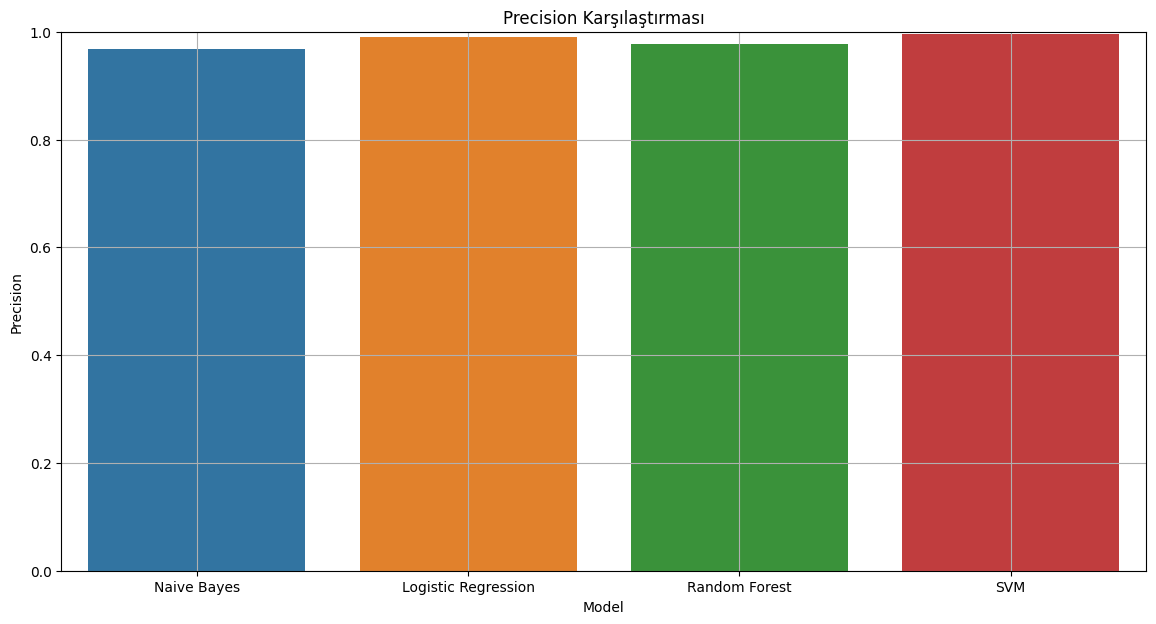

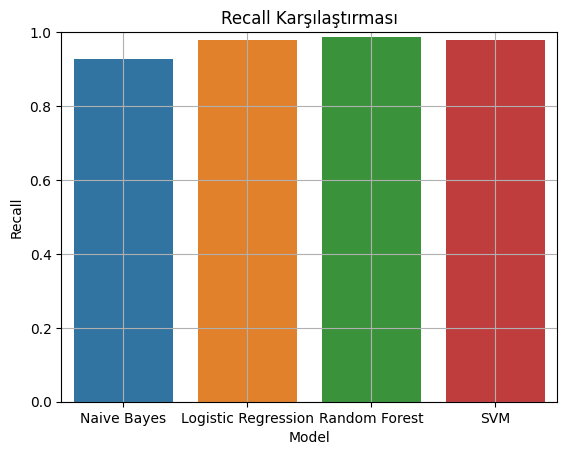

In [25]:

# Sonuçları DataFrame'e çevirmiştin:
metrics = ['Precision', 'Recall' ]
plt.figure(figsize=(14,7))

for metric in metrics:
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'{metric} Karşılaştırması')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()


Bu ısı haritası, modellerin çeşitli performans metrikleri arasındaki ilişkiyi incelemek için oluşturulmuştur.

• Accuracy, Precision, Recall ve F1-Score metrikleri arasındaki korelasyonlar hesaplanmış ve görselleştirilmiştir.

• Isı haritasında koyu kırmızı renkten koyu mavi renge doğru değişen tonlar, metrikler arasındaki pozitif veya negatif korelasyonların derecesini yansıtır.

• Hücre içindeki sayılar, ilgili iki metrik arasındaki Pearson korelasyon katsayısını gösterir. 1.0 mükemmel pozitif korelasyonu, -1.0 ise mükemmel  negatif korelasyonu ifade eder.

• Burada amaç, metriklerin birbirleriyle ne kadar örtüştüğünü anlamak ve hangi metriklerin performans değerlendirmesinde birbirini desteklediğini görmektir.

Bu analiz, model seçimi ve değerlendirmede hangi metriklerin birlikte kullanılmasının anlamlı olduğunu ortaya koyar.

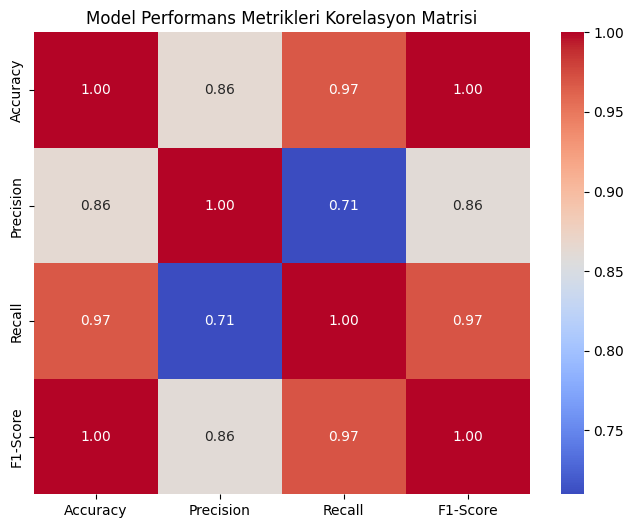

In [26]:
plt.figure(figsize=(8, 6))
corr = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Model Performans Metrikleri Korelasyon Matrisi")
plt.show()


Her model için oluşturulan karışıklık matrisleri, modelin doğru ve yanlış sınıflandırma performansını görsel olarak incelememize olanak sağlar:

• Ham (Non-Spam) ve Spam sınıfları için gerçek ve tahmin edilen etiketler karşılaştırılır.

• Matrisin diagonalindeki değerler (üst sol ve alt sağ hücreler) doğru sınıflandırmaları gösterirken,

• Diagonal dışındaki hücreler yanlış sınıflandırmaları ifade eder.

• Bu sayede modelin hangi sınıfta daha iyi veya kötü performans gösterdiği anlaşılır.

Her model için farklı renk paletleri (Blues, Greens, Purples, Oranges) kullanılarak karışıklık matrisleri görsel olarak ayrıştırılmıştır, böylece modeller kolayca karşılaştırılabilir.

Özetle, bu görseller:

• Modellerin spam ve ham mesajları ne kadar doğru ayırt ettiğini,

• Yanlış pozitif ve yanlış negatif oranlarını açık şekilde gösterir.

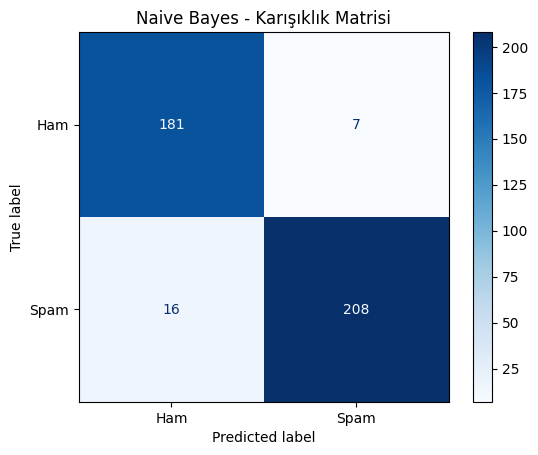

In [27]:

cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Ham', 'Spam'])
disp_nb.plot(cmap='Blues')
plt.title("Naive Bayes - Karışıklık Matrisi")
plt.show()


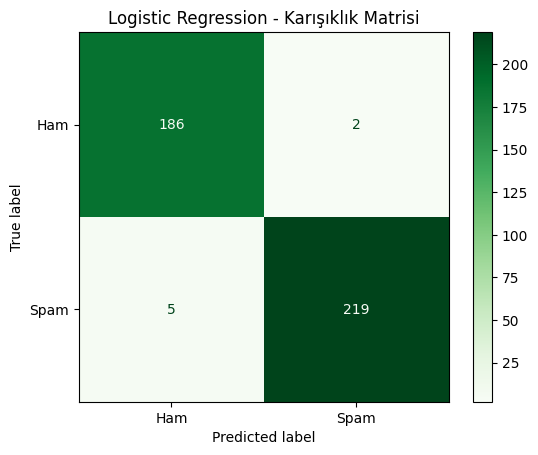

In [28]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Ham', 'Spam'])
disp_lr.plot(cmap='Greens')
plt.title("Logistic Regression - Karışıklık Matrisi")
plt.show()


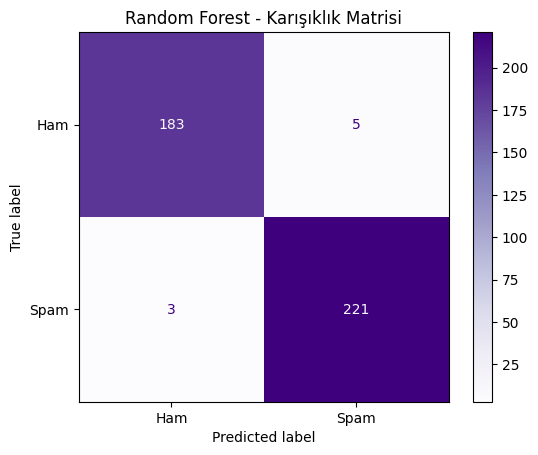

In [29]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Ham', 'Spam'])
disp_rf.plot(cmap='Purples')
plt.title("Random Forest - Karışıklık Matrisi")
plt.show()


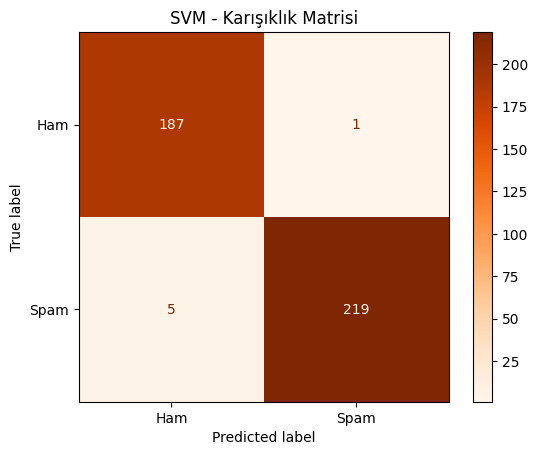

In [30]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Ham', 'Spam'])
disp_svm.plot(cmap='Oranges')
plt.title("SVM - Karışıklık Matrisi")
plt.show()


# **MODEL SONUÇLARI ve MODELİ TEST ETME**

Modelin hangi kelimeler üzerinden karar verdiğini daha iyi anlamak için, mesajlar sınıflarına (spam ve ham) ayrıldıktan sonra her sınıfa ait kelimeler incelendi. Temizlenmiş (noktalama işaretlerinden ve durak kelimelerinden arındırılmış) metinlerdeki kelimeler boşluklara göre bölünerek liste haline getirildi.

**Spam Mesajlar:** Tüm spam mesajlar birleştirildi ve içerisindeki kelimeler sayılarak en sık geçen 20 kelime belirlendi.

**Ham Mesajlar:** Benzer şekilde, normal (ham) mesajlardaki en sık geçen 20 kelime de ayrı olarak çıkarıldı.

Elde edilen veriler iki ayrı DataFrame'e aktarıldı ve sonuçlar karşılaştırmalı olarak yan yana gösterildi. Bu işlem, spam mesajların genellikle promosyon, ödül, para gibi kelimeler içerdiğini; ham mesajların ise daha gündelik ve bağlamsal kelimelerden oluştuğunu gözlemlemeye olanak tanır.

Bu analiz, modelin hangi kelimelere daha fazla "önem" verdiği konusunda içgörü sağlayarak özellik mühendisliği aşamasında fikir verir.

In [31]:
# Mesajları boşluklara göre ayırarak kelime listesi oluştur
spam_words = " ".join(df[df['label'] == 1]['message_cleaned']).split()
ham_words = " ".join(df[df['label'] == 0]['message_cleaned']).split()

# En sık geçen 20 kelimeyi bul
spam_common = Counter(spam_words).most_common(20)
ham_common = Counter(ham_words).most_common(20)

# DataFrame olarak göster
spam_df = pd.DataFrame(spam_common, columns=['Kelime', 'Spam Frekansı'])
ham_df = pd.DataFrame(ham_common, columns=['Kelime', 'Ham Frekansı'])

# Yan yana göstermek için:
combined_df = pd.concat([spam_df, ham_df], axis=1)
print(combined_df)


    Kelime  Spam Frekansı    Kelime  Ham Frekansı
0      yaz            676    NUMARA           210
1    iptal            595        tl           107
2     b013            571      b002           105
3    4607e            450      b003            87
4      sms            419      b016            76
5   gönder            377     bugün            67
6     55gm            239    teslim            66
7   gonder            214      yeni            58
8       tl            193      saat            56
9   NUMARA            131     iptal            54
10     -99             98      kodu            53
11  phebia             91      b001            52
12     son             91       sms            49
13   hemen             87   mersis:            46
14   4607'             81  internet            43
15    cuma             81     almak            43
16    phba             79     bilgi            40
17   kayit             69   degerli            40
18     oto             64     için:            39


Spam tespiti için metin verisinin içeriğini analiz etmek oldukça önemlidir. Bu çalışmada, temizlenmiş metin verileri üzerinden en sık geçen kelimeler çıkarılmış ve bu kelimelerin hem spam hem de ham mesajlarda hangi sıklıkta geçtiği kıyaslanmıştır.

Öncelikle, her iki sınıf için en sık geçen 10 kelime tespit edilmiştir. Ardından bu kelimeler birleştirilerek ortak bir kelime listesi oluşturulmuş, böylece spam ve ham mesajlar arasındaki içerik farkı daha net görülebilmiştir.

Elde edilen sonuçlar yatay çubuk grafik ile görselleştirilmiştir:

 • Kırmızı çubuklar, spam mesajlarda geçen kelimelerin frekansını gösterir.

 • Yeşil çubuklar, ham mesajlardaki karşılık gelen kelimelerin frekanslarını belirtir.

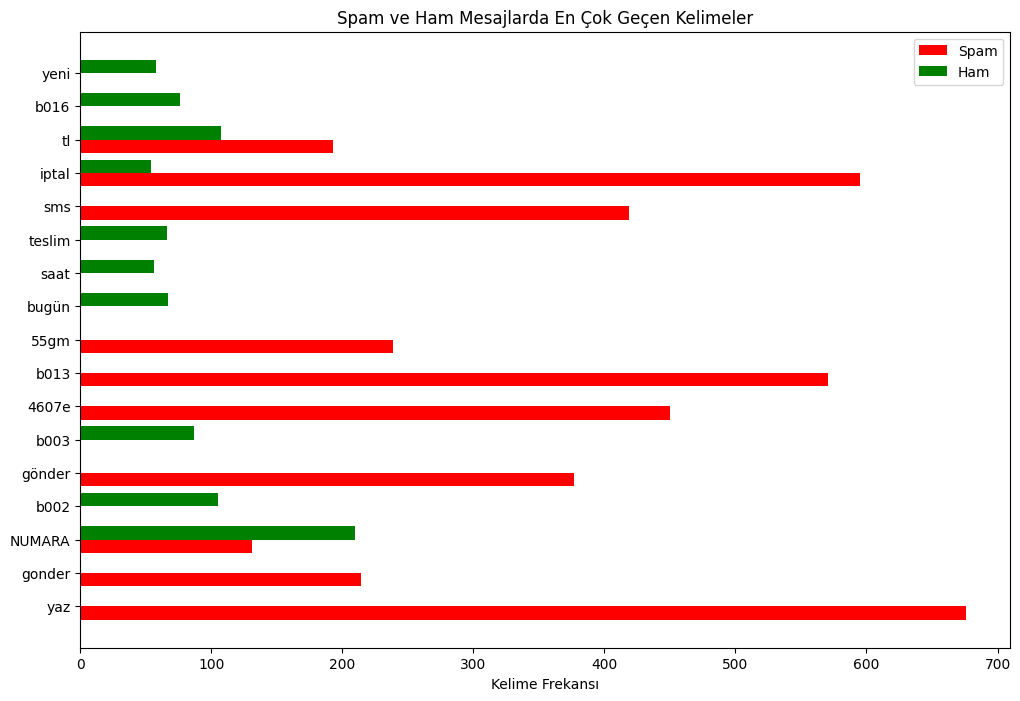

In [32]:

# Kelimeleri hazırla
spam_words = " ".join(df[df['label'] == 1]['message_cleaned']).split()
ham_words = " ".join(df[df['label'] == 0]['message_cleaned']).split()

spam_common = Counter(spam_words).most_common(10)
ham_common = Counter(ham_words).most_common(10)

# DataFrame'e çevir
import pandas as pd
spam_df = pd.DataFrame(spam_common, columns=['word', 'count'])
ham_df = pd.DataFrame(ham_common, columns=['word', 'count'])

# En çok geçen kelimelerden ortak olanları al
common_words = list(set(spam_df['word']).union(set(ham_df['word'])))

# Kelimelere göre countları eşitleyelim
spam_counts = [spam_df[spam_df['word'] == w]['count'].values[0] if w in spam_df['word'].values else 0 for w in common_words]
ham_counts = [ham_df[ham_df['word'] == w]['count'].values[0] if w in ham_df['word'].values else 0 for w in common_words]

# Grafik oluştur
plt.figure(figsize=(12,8))
bar_width = 0.4
indices = range(len(common_words))

plt.barh([i + bar_width for i in indices], spam_counts, height=bar_width, color='red', label='Spam')
plt.barh(indices, ham_counts, height=bar_width, color='green', label='Ham')

plt.yticks([i + bar_width/2 for i in indices], common_words)
plt.xlabel('Kelime Frekansı')
plt.title('Spam ve Ham Mesajlarda En Çok Geçen Kelimeler')
plt.legend()
plt.gca().invert_yaxis()
plt.show()


Modelin doğruluğunu sadece test verisiyle değil, aynı zamanda gerçek hayat senaryolarına yakın örneklerle test etmek amacıyla predict_messages() adında özel bir yardımcı fonksiyon oluşturulmuştur. Bu fonksiyonun temel işlevi, modelin spam ve ham mesajları ne kadar doğru sınıflandırabildiğini gözlemlemeyi kolaylaştırmaktır.

Fonksiyonun parametreleri şunlardır:

**messages**:Tahmin edilmek istenen mesajları içeren bir liste

**trained_model**: TF-IDF vektörleştirme ve sınıflandırıcı içeren, Pipeline yapısıyla eğitilmiş model

Örnek olarak verilen mesajlar üzerinde GridSearchCV ile optimize edilmiş SVM modeli (grid_svm.best_estimator_) kullanılarak tahmin yapılmıştır.

Bu fonksiyon sayesinde modelin gerçek dünya mesajlarında ne kadar etkili çalıştığı pratik olarak gözlemlenebilir.

In [33]:
def predict_messages(messages, trained_model):
    """
    Yeni gelen mesajların spam mi ham mı olduğunu tahmin eder.

    Parametreler:
    - messages (list): Tahmin edilmek istenen mesajlar (string listesi)
    - trained_model (Pipeline): TF-IDF ve sınıflandırıcı içeren eğitilmiş model

    Çıktı:
    - Ekrana her mesaj için tahmin sonucu (Spam veya Ham)
    """
    predictions = trained_model.predict(messages)

    for msg, pred in zip(messages, predictions):
        label = "Spam" if pred == 1 else "Ham"
        print(f"Mesaj: {msg}\n→ Tahmin: {label}\n")


# Örnek kullanım
sample_messages = [
    "Bugün saat 3’te kütüphanede buluşuyoruz, unutma!",
    "Kargonuz teslim edilemedi. Adresinizi güncelleyin: https://ptt-takip.xyz",
    "Starbucks’ta buluşalım mı, yeni kahveler gelmiş.",
    "Mobil ödeme ile TL kazanmak için HEMEN ARA",
    "%50 indirim! Bugün son gün. Hemen üye olun ve kazanın!",
    "Sayın abonemiz, faturanızı 24 saat içinde ödemezseniz hattınız kapatılacaktır. Bilginize",
    "Baba ben geldim, birazdan yemek yer miyiz?",
    "Liselere Geçiş Sistemi (LGS) sınavına girecek olan tüm öğrencilerimize başarılar diliyorum.",
    "Tebrikler! 500₺ kazandınız 🎁 Hemen https://ödülal.com adresinden çekin!",
    "PTT teslimatınız beklemede ❗ Adresinizi güncelleyin: https://ptt-kargo.org",
    "Mobil ödeme ile TL kazanmak için HEMEN ARA: 0850 000 00 00",

]
# Eğitilmiş en iyi modelin burada yüklü olmalı (örneğin):
# best_model = grid.best_estimator_  (örneğin Logistic Regression, Naive Bayes vs.)
# Aşağıdaki satırı kendi modeline göre değiştir:
best_model = grid_svm.best_estimator_  # grid: GridSearchCV ile eğittiğin nesne

predict_messages(sample_messages, best_model)


Mesaj: Bugün saat 3’te kütüphanede buluşuyoruz, unutma!
→ Tahmin: Ham

Mesaj: Kargonuz teslim edilemedi. Adresinizi güncelleyin: https://ptt-takip.xyz
→ Tahmin: Spam

Mesaj: Starbucks’ta buluşalım mı, yeni kahveler gelmiş.
→ Tahmin: Ham

Mesaj: Mobil ödeme ile TL kazanmak için HEMEN ARA
→ Tahmin: Spam

Mesaj: %50 indirim! Bugün son gün. Hemen üye olun ve kazanın!
→ Tahmin: Spam

Mesaj: Sayın abonemiz, faturanızı 24 saat içinde ödemezseniz hattınız kapatılacaktır. Bilginize
→ Tahmin: Ham

Mesaj: Baba ben geldim, birazdan yemek yer miyiz?
→ Tahmin: Ham

Mesaj: Liselere Geçiş Sistemi (LGS) sınavına girecek olan tüm öğrencilerimize başarılar diliyorum.
→ Tahmin: Ham

Mesaj: Tebrikler! 500₺ kazandınız 🎁 Hemen https://ödülal.com adresinden çekin!
→ Tahmin: Spam

Mesaj: PTT teslimatınız beklemede ❗ Adresinizi güncelleyin: https://ptt-kargo.org
→ Tahmin: Spam

Mesaj: Mobil ödeme ile TL kazanmak için HEMEN ARA: 0850 000 00 00
→ Tahmin: Spam

